# 01) Importar librerias correspondientes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# 02) Importar dataset de properati

In [2]:
prop = pd.read_csv('properati_data.csv')

In [3]:
prop.head()

,id,created_on,operation,property_type,neighbourhood,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses
0,1649a3c35359d681abae4a63d9a8545054d2096b,2017-09-22,sell,house,Palermo Viejo,-34.588953,-58.429882,2000000.0,312.0,NaN,NaN,NaN,NaN
1,1ab035ccbe77702987c3f09850d12c634e612aa2,2017-09-01,sell,PH,Parque Chacabuco,-34.635866,-58.431048,131500.0,80.0,50.0,NaN,3.0,NaN
2,90fc7c61b6fbc6ef99368a21cd9ac0d30d54c697,2017-09-01,sell,apartment,Barracas,-34.644924,-58.371919,140000.0,125.0,85.0,NaN,NaN,NaN
3,c195e8f3a596ab49b95d699c07e1a04be503ba68,2017-09-01,sell,apartment,Recoleta,-34.596511,-58.385747,109000.0,45.0,45.0,2.0,2.0,3350.0
4,f891875ff44e6f99e30e101b3901d1e7510ef41b,2017-09-01,sell,apartment,Parque Patricios,-34.639173,-58.417069,94000.0,38.0,38.0,NaN,NaN,NaN


In [9]:
prop.shape

(25319, 13)

In [4]:
prop.describe()

,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses
count,24271.000000,24271.000000,2.339100e+04,21996.000000,22790.000000,3226.000000,18712.000000,5030.000000
mean,-34.596901,-58.459714,3.795836e+05,136.523413,117.415796,10.201178,2.896056,4541.263221
std,0.234335,0.383639,6.740833e+05,1621.765815,1334.830021,49.599295,1.793474,6759.184562
min,-38.416097,-68.466206,1.111100e+04,0.000000,1.000000,1.000000,1.000000,1.000000
25%,-34.619699,-58.464153,1.210000e+05,45.000000,41.000000,2.000000,2.000000,1500.000000
50%,-34.601482,-58.434383,1.870000e+05,70.000000,62.000000,4.000000,3.000000,2800.000000
75%,-34.583162,-58.401197,3.450000e+05,123.000000,108.000000,7.000000,4.000000,5100.000000
max,-26.861151,-58.353227,1.725144e+07,184000.000000,150000.000000,904.000000,38.000000,184361.000000


# 03) Revisar con que columnas trabajar para luego quitarle los NaNs (queremos predecir precio)

In [5]:
prop.isnull().sum()

id                           0
created_on                   0
operation                    0
property_type                0
neighbourhood                0
lat                       1048
lon                       1048
price                     1928
surface_total_in_m2       3323
surface_covered_in_m2     2529
floor                    22093
rooms                     6607
expenses                 20289
dtype: int64

In [9]:
# Eliminar columnas que no son necesarias
#por utilidad
prop.drop(['id', 'created_on', 'lat', 'lon', 'operation'], axis= 1, inplace = True)
#por NaNs
prop.drop(['floor', 'expenses'], axis= 1, inplace= True)

In [10]:
# Eliminar samples con NaNs
prop.dropna(subset= ['rooms', 'price', 'surface_total_in_m2', 'surface_covered_in_m2'], inplace= True)

In [11]:
prop.shape

(16296, 6)

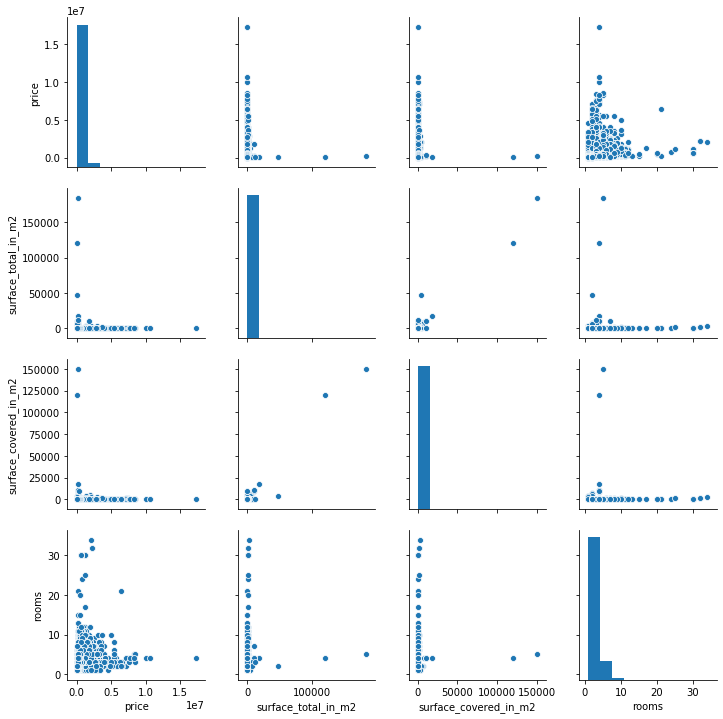

In [12]:
sns.pairplot(prop)

# 04) Quitar Outliers de las variables que consideren utilizando cuantiles

In [13]:
# Checkear quantiles y ver si las medidas tienen sentido
# Precios más altos
price_q97 = prop.price.quantile(0.975)
# Superficie total
surface_total_q97 = prop.surface_total_in_m2.quantile(0.975)
# Superficie cubierta
surface_cov_q97 = prop.surface_covered_in_m2.quantile(0.975)
# Cant de cuartos
rooms_q97 = prop.rooms.quantile(0.975)
# Cuartil 0.1 de precios más bajos
price_q01 = prop.price.quantile(0.001)

([<matplotlib.axis.XTick at 0x7f7f378024a8>,
 <a list of 17 Text xticklabel objects>)

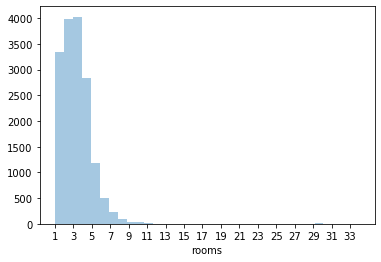

In [17]:
# Checkear la distribución de número de cuartos
sns.distplot(prop.rooms, kde = False, bins = int(prop.rooms.max()))
plt.xticks(ticks= range(1,35,2))

In [10]:
rooms_q97 # El cuantil 97.5 es 7 rooms, selecciono 10 habitaciones como tope máximo según la distribución

7.0

In [18]:
prop_filt = prop.loc[(prop.price < price_q97) & (prop.surface_covered_in_m2 < surface_cov_q97) &
                     (prop.surface_total_in_m2 < surface_total_q97) &
                     (prop.rooms <= 10) & (prop.price > price_q01) & 
                     (prop.surface_covered_in_m2 < prop.surface_total_in_m2)]
# Quito también aquellas propiedades que tienen una superficie cubierta mayor a superficie total (no tiene sentido)

In [19]:
prop_filt.shape

(10571, 6)

In [20]:
prop_filt.head()

,property_type,neighbourhood,price,surface_total_in_m2,surface_covered_in_m2,rooms
1,PH,Parque Chacabuco,131500.0,80.0,50.0,3.0
7,apartment,Villa Crespo,240435.0,101.0,75.0,3.0
8,apartment,Villa Devoto,370000.0,225.0,200.0,5.0
11,apartment,Boedo,83000.0,50.0,40.0,2.0
12,apartment,Barracas,110000.0,63.0,48.0,2.0


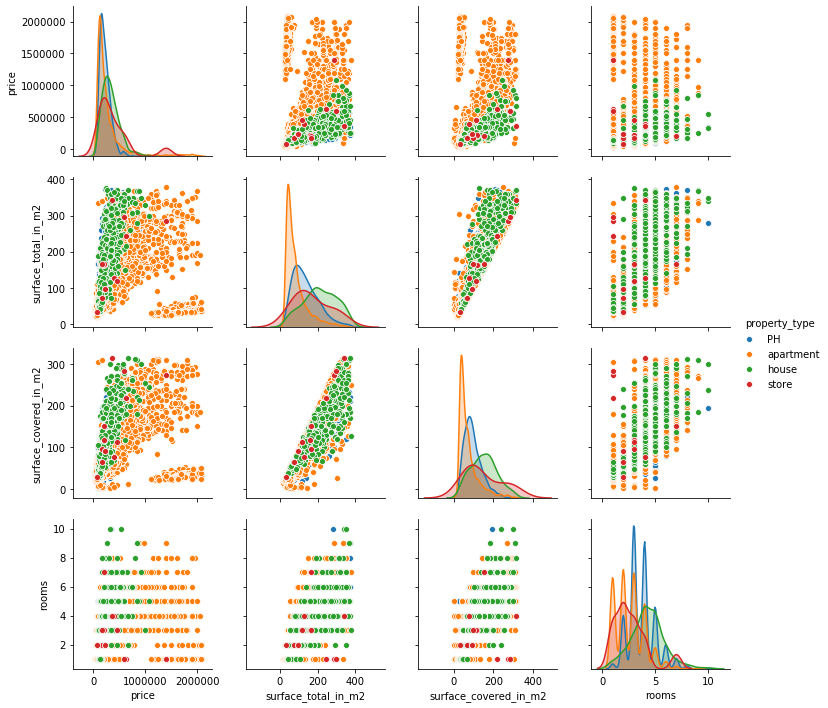

In [24]:
sns.pairplot(prop_filt, hue= 'property_type')

### Prueba

In [28]:
prueba = prop_filt.loc[(prop_filt.price > 1000000) & (prop_filt.surface_total_in_m2 < 100)]

In [33]:
prueba.shape

(226, 6)

In [34]:
prueba.describe()

,price,surface_total_in_m2,surface_covered_in_m2,rooms
count,2.260000e+02,226.000000,226.000000,226.000000
mean,1.696538e+06,37.159292,31.964602,1.115044
std,2.415488e+05,9.300482,7.206700,0.371237
min,1.100161e+06,25.000000,21.000000,1.000000
25%,1.535492e+06,32.000000,28.000000,1.000000
50%,1.715550e+06,35.000000,31.000000,1.000000
75%,1.900000e+06,41.000000,35.000000,1.000000
max,2.086176e+06,92.000000,85.000000,4.000000


In [83]:
# Remuevo estos "outliers de dataframe filtrado"
prop_filt2 = prop_filt[~prop_filt.isin(prueba)].dropna()

In [38]:
prop_filt2.shape

(10345, 6)

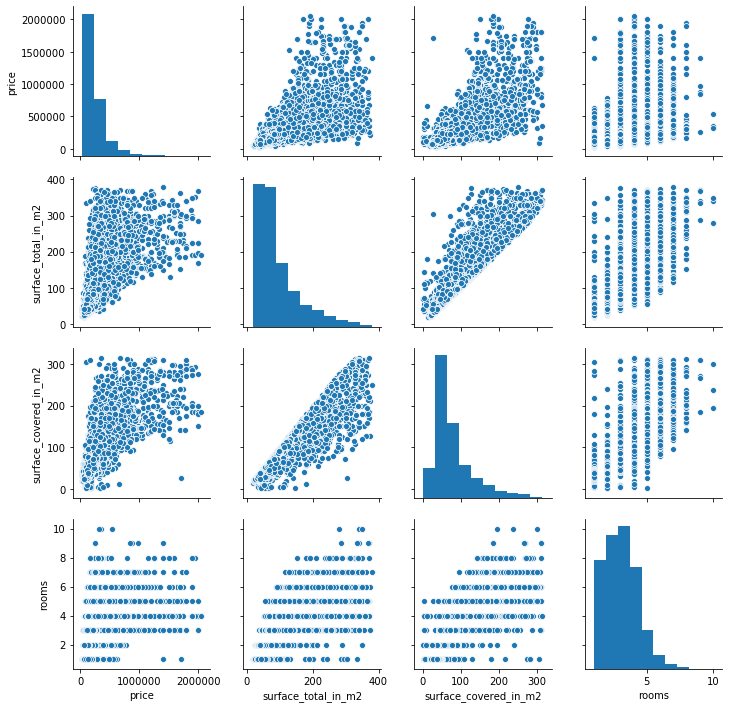

In [39]:
sns.pairplot(prop_filt2)

------------------------------

# 05) Realizar feature engineering si fuera necesario

In [31]:
prop.neighbourhood.unique()

array(['Parque Chacabuco', 'Recoleta', 'Flores', 'Caballito',
       'Villa Crespo', 'Villa Devoto', 'Boedo', 'Barracas', 'Saavedra',
       'Paternal', 'Nuñez', 'Puerto Madero', 'Retiro', 'Belgrano',
       'Palermo', 'Almagro', 'Barrio Norte', 'San Cristobal', 'San Telmo',
       'Las Cañitas', 'Palermo Hollywood', 'Palermo Soho',
       'Palermo Chico', 'San Nicolás', 'Mataderos', 'Floresta',
       'Villa General Mitre', 'Boca', 'Villa Urquiza', 'Once', 'Coghlan',
       'Capital Federal', 'Monte Castro', 'Monserrat', 'Villa Lugano',
       'Parque Patricios', 'Chacarita', 'Liniers', 'Abasto', 'Colegiales',
       'Balvanera', 'Constitución', 'Congreso', 'Agronomía', 'Tribunales',
       'Villa Santa Rita', 'Villa Luro', 'Villa del Parque',
       'Villa Pueyrredón', 'Centro / Microcentro', 'Versalles',
       'Velez Sarsfield', 'Villa Ortuzar', 'Parque Chas', 'Pompeya',
       'Parque Avellaneda', 'Villa Real', 'Parque Centenario',
       'Palermo Viejo', 'Villa Soldati', 'Catalin

In [102]:
neigh_dummie = pd.get_dummies(prop.neighbourhood)
neigh_dummie.head(3)

,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,Boca,Boedo,Caballito,...,Villa General Mitre,Villa Lugano,Villa Luro,Villa Ortuzar,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
type_dummie = pd.get_dummies(prop.property_type)
type_dummie.head()

,PH,apartment,house,store
1,1,0,0,0
3,0,1,0,0
5,0,1,0,0
6,0,1,0,0
7,0,1,0,0


In [103]:
prop_filt = prop_filt.join([neigh_dummie, type_dummie])

In [104]:
prop_filt.shape

(10571, 71)

# 06) Separar Y (price) & X (decidir que features utilizar para trabajar)
Recuerden realizar auto scaling sobre las variables en cuestion

In [105]:
y = prop_filt['price']

In [106]:
X = prop_filt.drop(['price','neighbourhood', 'property_type'], axis= 1)

In [107]:
X.head()

,surface_total_in_m2,surface_covered_in_m2,rooms,Abasto,Agronomía,Almagro,Balvanera,Barracas,Barrio Norte,Belgrano,...,Villa Pueyrredón,Villa Real,Villa Santa Rita,Villa Soldati,Villa Urquiza,Villa del Parque,PH,apartment,house,store
1,80.0,50.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,101.0,75.0,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,225.0,200.0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11,50.0,40.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,63.0,48.0,2.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [108]:
# Separar train y test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [109]:
X_train.shape

(7928, 68)

In [110]:
# Generar scaler fiteado a X train
scaler = preprocessing.StandardScaler().fit(X_train)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [111]:
# -Escalar X train
X_train_scal = scaler.transform(X_train)  

In [112]:
# Escalar X test
X_test_scal = scaler.transform(X_test)  

# 07) Implementar un modelo de regresion para predecir el precio. De ser posible comparar performance de distintos modelos.

In [113]:
lr = LinearRegression()

In [114]:
lr.fit(X_train_scal, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
y_pred = lr.predict(X_test_scal)

In [116]:
y_pred.shape

(2643,)

In [117]:
# Computo MAE
MAE_lr = mean_absolute_error(y_test, y_pred)
MAE_lr

122007.60480267002

In [118]:
# Computo RMSE
RMSE_lr = np.sqrt(mean_squared_error(y_test, y_pred))
RMSE_lr

248721.22617345734

Text(0.5, 0, 'real')

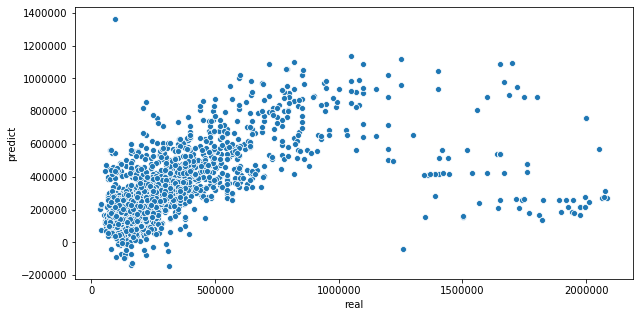

In [119]:
plt.figure(figsize= (10,5))
sns.scatterplot(y_test, y_pred)
plt.ylabel('predict')
plt.xlabel('real')

# KNN

In [49]:
neigh = KNeighborsRegressor(weights = "distance")

In [50]:
parameters_k = np.arange(20,31,1)
parameters_k

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [51]:
parameters_knn = [{'n_neighbors': parameters_k}]

In [52]:
regresor_neigh = GridSearchCV(neigh, parameters_knn, refit = True, cv=10, verbose=True)

In [53]:
regresor_neigh.fit(X_train_scal, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  5.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='distance'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [54]:
regresor_neigh.best_params_

{'n_neighbors': 26}

In [55]:
regresor_neigh.best_score_

0.6731762179664813

In [56]:
y_pred2 = regresor_neigh.predict(X_test_scal)


In [73]:
# Computo RMSE
RMSE_knn = np.sqrt(mean_squared_error(y_test, y_pred2))
RMSE_knn

184034.08459451576

In [74]:
# computo MAE (mean absolute error)
MAE_knn = mean_absolute_error(y_test, y_pred2)
MAE_knn

70173.94706805961

Text(0.5, 0, 'real')

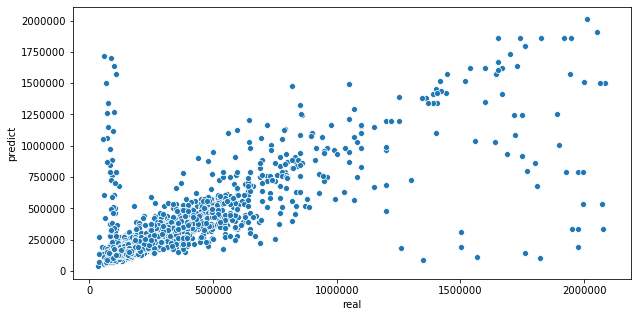

In [59]:
plt.figure(figsize= (10,5))
sns.scatterplot(y_test, y_pred2)
plt.ylabel('predict')
plt.xlabel('real')

# SVR

In [60]:
svreg = SVR()

In [61]:
parameters_svr = [{'kernel':['rbf', 'linear'] , 'C': [1,10,100],'gamma': [0.1,0.5] }]

In [62]:
regresor_svr = GridSearchCV(svreg, parameters_svr, cv=5, verbose=True)

In [63]:
regresor_svr.fit(X_train_scal, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100], 'gamma': [0.1, 0.5],
                          'kernel': ['rbf', 'linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [64]:
regresor_svr.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}

In [65]:
regresor_svr.best_score_

0.24070903352100465

In [66]:
y_pred3 = regresor_svr.predict(X_test_scal)

In [68]:
# Computo RMSE
RMSE_svr = np.sqrt(mean_squared_error(y_test, y_pred3))
RMSE_svr

267284.00069995126

In [69]:
# computo MAE (mean absolute error)
MAE_svr = mean_absolute_error(y_test, y_pred3)
MAE_svr

94228.06214984112

Text(0.5, 0, 'real')

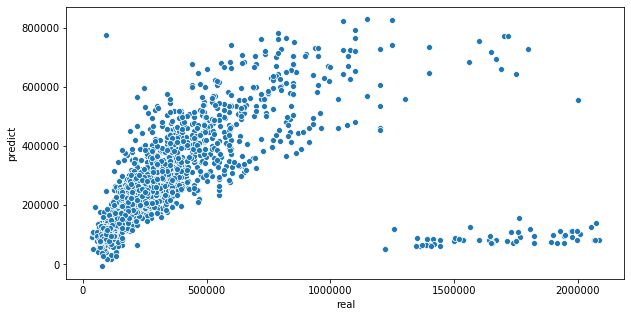

In [70]:
plt.figure(figsize= (10,5))
sns.scatterplot(y_test, y_pred3)
plt.ylabel('predict')
plt.xlabel('real')

# SUMMARY

In [79]:
print('SCORES:')
print(f'RMSEs for Linear Regression: {RMSE_lr}, KNN: {RMSE_knn}, SVR: {RMSE_svr}')
print(f'MAEs for Linear Regression: {MAE_lr}, KNN: {MAE_knn}, SVR: {MAE_svr}')


SCORES:
RMSEs for Linear Regression: 248721.22617345734, KNN: 184034.08459451576, SVR: 267284.00069995126
MAEs for Linear Regression: 122007.60480267002, KNN: 70173.94706805961, SVR: 94228.06214984112


Text(0.5, 0, 'real')

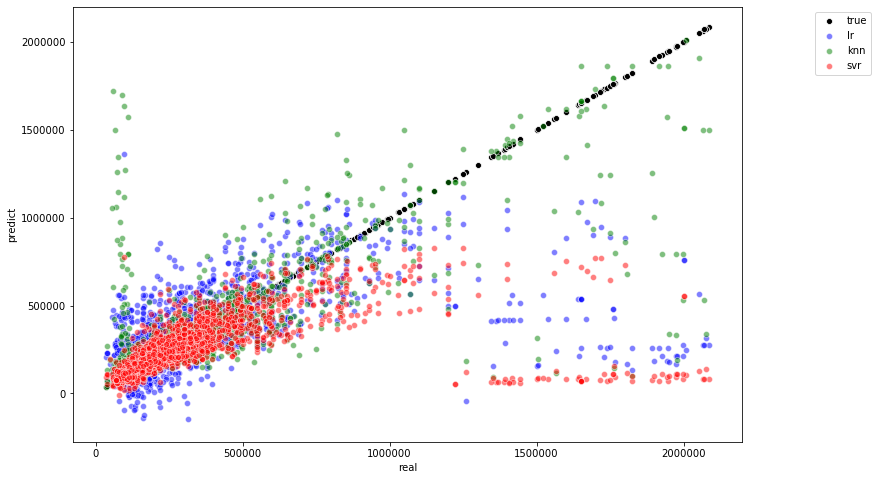

In [90]:
plt.figure(figsize= (12,8))
sns.scatterplot(y_test, y_test, color= 'black', label = 'true')
sns.scatterplot(y_test, y_pred, color= 'blue', label = 'lr', alpha = 0.5)
sns.scatterplot(y_test, y_pred2, color= 'green', label = 'knn', alpha = 0.5)
sns.scatterplot(y_test, y_pred3, color= 'red', label = 'svr', alpha = 0.5)
plt.legend(loc= 'upper right', bbox_to_anchor=(1.2, 1))
plt.ylabel('predict')
plt.xlabel('real')